<a href="https://colab.research.google.com/github/Dinmir331/Semester8_LB2/blob/main/S8_CV_LB2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2 лаба -- нужно взять 2 изображения (2 фотки пола например со сдвигом на сколько то сантиметров) или более и построить траекторию движения камеры, выполнив следующие пункты

Определите на каждой фотографии ключевые точки

Отфильтруйте самые наилучшие применяя адаптивный радиус и локальные максимумы, не забудьте так же выровнять по яркости изображения.

Постройте по каждой точке дескриптор (можете использовать любой, рекомендуется SIFT)

Сопоставьте два соседних изображения на предмет соответствия ключевых точек. То есть определите пары одинаковых точек.

Постройте модель преобразования изображений, учитывайте только поворот и сдвиг.
С учетом полученных моделей постройте траекторию движения камеры.

////////////////


Задача стостоит загрузить две картинки, одна из которых имеет смещение относительно другой. Это могут быть искуственносозданные ситуации.

Итак, надо будет сделать следующий пул задач:

Выбрать алгоритм поиска опорных точек

Фильтрация опорных точек

Сопастовление опорных точеки на двух ихображений

Сделать выводы

Задача сводится к нахождению опорных точек и сопастовлению.

# Загрузка библиотек и данных. функции отображения изображений

## Основные библиотеки и подключение гугл диска

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

# Подключение Google Drive для загрузки изображения
from google.colab import drive
drive.mount('/content/drive')

# Чтение изображения с использованием OpenCV и преобразование его в RGB
image1_path = '/content/drive/MyDrive/Colab Notebooks/LB2_IMAGE1_3.jpg'
image2_path = '/content/drive/MyDrive/Colab Notebooks/LB2_IMAGE1_4.jpg'
image3_path = '/content/drive/MyDrive/Colab Notebooks/LB2_IMAGE1_5.jpg'
image4_path = '/content/drive/MyDrive/Colab Notebooks/LB2_IMAGE1_6.jpg'


image1 = cv2.imread(image1_path)
image2 = cv2.imread(image2_path)
image3 = cv2.imread(image3_path)
image4 = cv2.imread(image4_path)


image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)  # Преобразование из BGR в RGB
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
image3 = cv2.cvtColor(image3, cv2.COLOR_BGR2RGB)
image4 = cv2.cvtColor(image4, cv2.COLOR_BGR2RGB)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Функция выравнивания яркости с адаптивным CLAHE

In [ ]:
# Функция выравнивания яркости с адаптивным CLAHE
def adjust_brightness(img):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    l = clahe.apply(l)
    return cv2.cvtColor(cv2.merge([l,a,b]), cv2.COLOR_LAB2RGB)

# Применение коррекции яркости
image1_adj = adjust_brightness(image1)
image2_adj = adjust_brightness(image2)
image3_adj = adjust_brightness(image3)
image4_adj = adjust_brightness(image4)

# Обнаружение ключевых точек с ограничением количества

## SIFT встроенный

In [ ]:
# sift = cv2.SIFT_create(nfeatures=500,
#                       contrastThreshold=0.05,
#                       edgeThreshold=20)

# keypoints1, descriptors1 = sift.detectAndCompute(image1_adj, None)
# keypoints2, descriptors2 = sift.detectAndCompute(image2_adj, None)
# keypoints3, descriptors3 = sift.detectAndCompute(image3_adj, None)
# keypoints4, descriptors4 = sift.detectAndCompute(image4_adj, None)

##SIFT

In [ ]:
# Параметры contrast_thresh и edge_thresh  зависят от масштаба:
# На мелких масштабах контрастные области могут быть менее заметны, и точки могут отсеиваться.
# На крупных масштабах края становятся более выраженными, что может привести к удалению точек на границах объектов.

# Меньшие значения scale (например, 1.0) подходят для мелких деталей.
# Большие значения scale (например, 8.0) подходят для крупных структур.

def homemade_sift(image,
                 nfeatures=1000,
                 contrast_thresh=0.02,  # порог контраста
                 edge_thresh=12,        # порог краев
                 scales=[1.0, 1.6, 2.56, 4.0]):  # масштабы

    # 1. Предобработка изображения
    gray = image if len(image.shape) == 2 else cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    h, w = gray.shape

    # 2. Нахождение ключевых точек
    keypoints = []
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    magnitude = np.sqrt(sobelx**2 + sobely**2)

    for scale in scales:
        blurred = cv2.GaussianBlur(gray, (0, 0), scale)
        if scale > scales[0]:
            dog = np.abs(blurred - prev_blur)

            for y in range(5, h-5):
                for x in range(5, w-5):
                    # Понижен порог контраста
                    if dog[y, x] < contrast_thresh:
                        continue

                    # Проверка на локальный экстремум
                    neighborhood = dog[y-2:y+3, x-2:x+3]  # 5x5 окно
                    if dog[y, x] != np.max(neighborhood) and dog[y, x] != np.min(neighborhood):
                        continue

                    # Улучшенная проверка краев
                    trace = sobelx[y, x]**2 + sobely[y, x]**2
                    det = (sobelx[y, x] * sobely[y, x])**2
                    if det == 0 or trace**2 / det > edge_thresh:
                        continue

                    keypoints.append(cv2.KeyPoint(x=x, y=y,
                                                 size=scale*2.5,  # Увеличен размер точки
                                                 response=magnitude[y, x]))
        prev_blur = blurred

    # 3. Фильтрация и сортировка
    keypoints = sorted(keypoints, key=lambda kp: kp.response, reverse=True)

    # Адаптивная фильтрация для достижения nfeatures
    if len(keypoints) > nfeatures:
        keypoints = keypoints[:nfeatures]
    else:
        # Ослабляем требования при недостатке точек
        keypoints += [kp for kp in keypoints_sorted
                     if kp.size > 8 and kp.response > contrast_thresh/2][:nfeatures]

    # 4. Назначение ориентации
    orientation = np.arctan2(sobely, sobelx) * 180 / np.pi
    for kp in keypoints:
      x, y = int(kp.pt[0]), int(kp.pt[1])
      # Расширенная область для гистограммы
      hist, _ = np.histogram(orientation[y-12:y+12, x-12:x+12],
                          bins=72, range=(-180, 180))  # 72 бина
      dominant_angle = np.argmax(hist)
      kp.angle = float(dominant_angle * 5 - 180)  # 5 градусов на бин

    # 5. Улучшенные дескрипторы
    descriptors = []
    # Создаем гауссову маску 24x24
    sigma = 16
    y, x = np.mgrid[-sigma:sigma, -sigma:sigma]
    gaussian_mask = np.exp(-(x**2 + y**2)/(2*sigma**2))

    for kp in keypoints:
        x_center, y_center = int(kp.pt[0]), int(kp.pt[1])
        size = int(kp.size * 1.5)  # размер дескриптора в 1.5 больше
        angle = np.deg2rad(kp.angle)
        cos = np.cos(angle)
        sin = np.sin(angle)

        desc = np.zeros((8, 8, 8))  # 8x8 блока × 8 бинов

        for i in range(8):
            for j in range(8):
                base_x = j * 3 - sigma  # 3 пикселя на блок
                base_y = i * 3 - sigma

                for dx in range(3):
                    for dy in range(3):
                        rx = (base_x + dx) * cos - (base_y + dy) * sin
                        ry = (base_x + dx) * sin + (base_y + dy) * cos
                        px = int(x_center + rx)
                        py = int(y_center + ry)

                        if 0 <= px < w and 0 <= py < h:
                            # Вес из гауссовой маски
                            weight = gaussian_mask[base_y + dy + sigma, base_x + dx + sigma]
                            mag = magnitude[py, px] * weight
                            ori = orientation[py, px] - kp.angle
                            ori = ori % 360
                            bin = int(ori // 45) % 8
                            desc[i, j, bin] += mag

        # Многократная нормализация
        desc = desc.flatten()
        desc = np.clip(desc, 0, 0.2*np.max(desc))  # Ограничение максимума
        desc /= np.linalg.norm(desc) + 1e-7
        descriptors.append(desc)

    return keypoints, np.array(descriptors, dtype=np.float32)

##Вывод ключевых точек

In [ ]:
keypoints1, descriptors1 = homemade_sift(image1_adj)
keypoints2, descriptors2 = homemade_sift(image2_adj)
keypoints3, descriptors3 = homemade_sift(image3_adj)
keypoints4, descriptors4 = homemade_sift(image4_adj)

Обнаружено точек: 1000, 1000, 1000, 1000


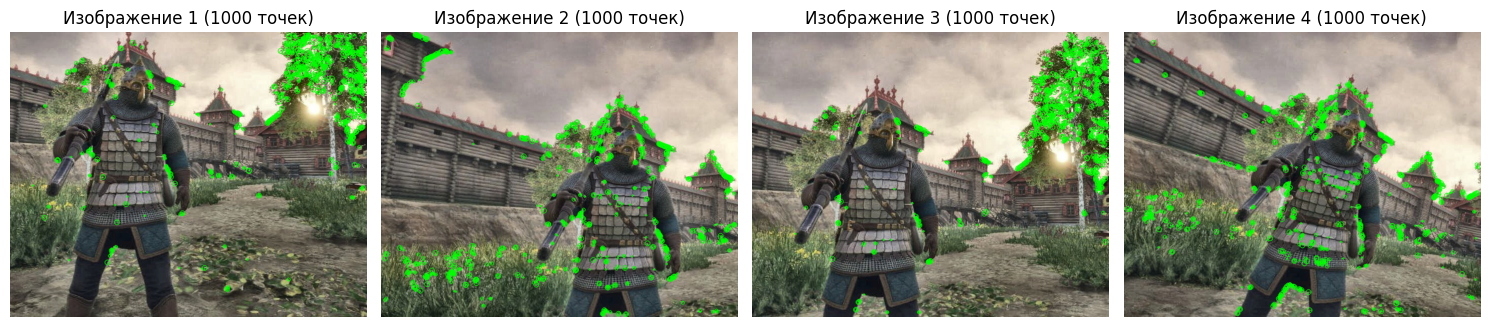

In [ ]:
print(f"Обнаружено точек: {len(keypoints1)}, {len(keypoints2)}, {len(keypoints3)}, {len(keypoints4)}")

def visualize_keypoints(images, keypoints_list):
    plt.figure(figsize=(15, 7))
    for i, (img, kps) in enumerate(zip(images, keypoints_list), 1):
        # Конвертируем RGB в BGR для OpenCV
        if len(img.shape) == 3 and img.shape[2] == 3:
            img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        else:
            img_bgr = img

        # Рисуем точки
        img_with_kp = cv2.drawKeypoints(
            img_bgr,
            kps,
            None,
            color=(0, 255, 0),
            flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
        )

        # Конвертируем обратно в RGB для matplotlib
        img_rgb = cv2.cvtColor(img_with_kp, cv2.COLOR_BGR2RGB)

        plt.subplot(1, len(images), i)
        plt.imshow(img_rgb)
        plt.title(f'Изображение {i} ({len(kps)} точек)')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Пример использования:
visualize_keypoints([image1_adj, image2_adj, image3_adj, image4_adj],
                    [keypoints1, keypoints2, keypoints3, keypoints4])

# Сопоставление и фильтрация совпадений встроенными функциями

In [ ]:
# bf = cv2.BFMatcher()
# matches = bf.knnMatch(descriptors1, descriptors2, k=4)

# # Фильтрация по Lowe's ratio test
# good_matches = [m for m,n in matches if m.distance < 0.7*n.distance]

# print(f"Найдено совпадений: {len(good_matches)}")

# Сопоставление и фильтрация совпадений


In [ ]:
def manual_descriptor_matching(desc1, desc2, ratio=0.8):
    matches = []
    for idx1, d1 in enumerate(desc1):
        # Вычисляем расстояния до всех дескрипторов второго изображения
        distances = np.sqrt(np.sum((desc2 - d1)**2, axis=1))

        # Получаем индексы двух ближайших соседей
        nn = np.argsort(distances)[:2]

        # Проверяем ratio test
        if distances[nn[0]] < ratio * distances[nn[1]]:
            matches.append(cv2.DMatch(
                _queryIdx=idx1,
                _trainIdx=nn[0],
                _distance=distances[nn[0]]
            ))
    return matches

# Списки для хранения данных
images_adj = [image1_adj, image2_adj, image3_adj, image4_adj]
keypoints = [keypoints1, keypoints2, keypoints3, keypoints4]
descriptors = [descriptors1, descriptors2, descriptors3, descriptors4]

# Создаем список пар
num_images = len(images_adj)
pairs = []
for i in range(num_images - 1):
    pairs.append((i, i+1))  # Последовательные пары
pairs.append((0, num_images - 1))  # Первая-последняя

pair_matches = []

# Обрабатываем все пары
for idx, (i, j) in enumerate(pairs):
    if descriptors[i] is None or descriptors[j] is None:
        print(f"Пара {i+1}-{j+1}: дескрипторы отсутствуют")
        pair_matches.append([])
        continue

    # Ручное сопоставление
    matches = manual_descriptor_matching(descriptors[i], descriptors[j])
    pair_matches.append(matches)
    print(f"Пара {i+1}-{j+1}: Найдено {len(matches)} совпадений")

Пара 1-2: Найдено 23 совпадений
Пара 2-3: Найдено 30 совпадений
Пара 3-4: Найдено 10 совпадений
Пара 1-4: Найдено 24 совпадений


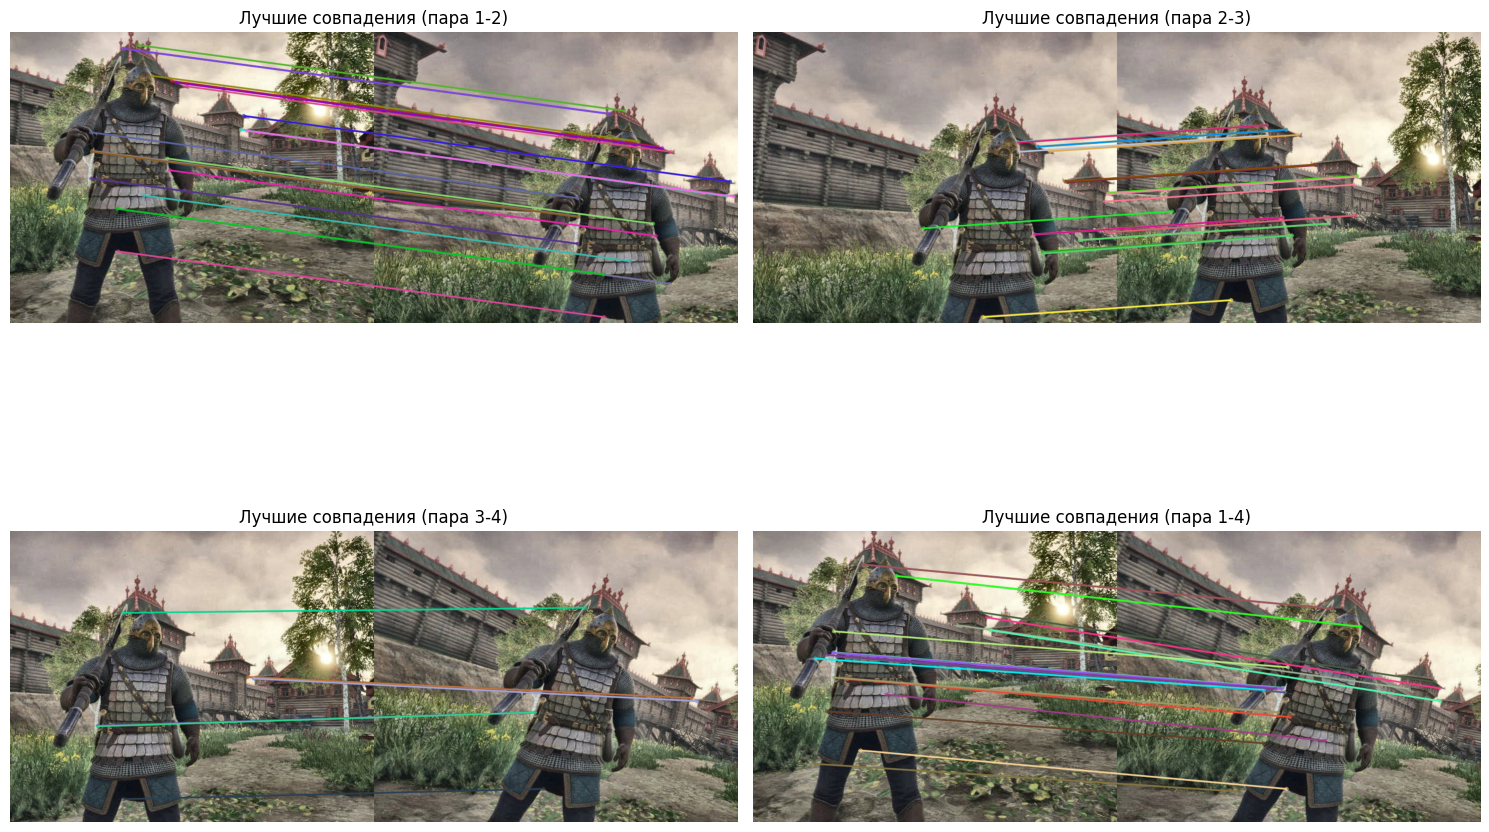

In [ ]:
# Визуализация с использованием OpenCV
plt.figure(figsize=(15, 12))
for idx, (i, j) in enumerate(pairs):
    if len(pair_matches[idx]) == 0:
        continue

    plt.subplot(2, 2, idx+1)
    match_img = cv2.drawMatches(
        images_adj[i], keypoints[i],
        images_adj[j], keypoints[j],
        pair_matches[idx][:50], None, # лучшие 50 совпадений
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
        matchesThickness=2             # Толщина линий
    )
    plt.imshow(match_img)
    plt.title(f'Лучшие совпадения (пара {i+1}-{j+1})')
    plt.axis('off')

plt.tight_layout()
plt.show()

# оценка с использованием встроенной функции

In [ ]:
# trajectory = [(0, 0)]  # Начальная позиция
# current_pos = np.array([0.0, 0.0])
# total_rotation = 0.0

# plt.figure(figsize=(10, 10))

# for i in range(3):  # Две пары изображений
#     good_matches = pair_matches[i]
#     if len(good_matches) < 4:
#         print(f"Пара {i+1}-{i+2}: недостаточно совпадений")
#         continue

#     # Получение координат точек
#     src_pts = np.float32([keypoints[i][m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
#     dst_pts = np.float32([keypoints[i+1][m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

#     # Оценка преобразования
#     M, _ = cv2.estimateAffinePartial2D(src_pts, dst_pts,
#                                       ransacReprojThreshold=3.0,
#                                       confidence=0.99)
#     if M is None:
#         print(f"Пара {i+1}-{i+2}: ошибка оценки преобразования")
#         continue

#     # Извлечение параметров движения
#     dx = -M[0, 2] # Инвертируем знак смещения по X
#     dy = M[1, 2]
#     rotation = np.arctan2(M[1, 0], M[0, 0]) * 180 / np.pi


#     # Обновление траектории
#     current_pos += np.array([dx, dy])
#     total_rotation += rotation
#     trajectory.append(tuple(current_pos))

# Оценка преобразования и траектории

In [ ]:
def estimate_affine_transform(src_pts, dst_pts):
    """
    Оценивает аффинное преобразование между двумя наборами точек.
    Возвращает матрицу преобразования 2x3.
    """
    # Формируем систему уравнений для Least Squares
    A = []
    b = []
    for (x1, y1), (x2, y2) in zip(src_pts, dst_pts):
        A.append([x1, y1, 1, 0, 0, 0])
        A.append([0, 0, 0, x1, y1, 1])
        b.append(x2)
        b.append(y2)

    # Решаем систему уравнений методом наименьших квадратов
    A = np.array(A)
    b = np.array(b)
    params, _, _, _ = np.linalg.lstsq(A, b, rcond=None)

    # Формируем матрицу преобразования
    M = np.array([
        [params[0], params[1], params[2]],
        [params[3], params[4], params[5]]
    ])
    return M

def apply_ransac(src_pts, dst_pts, threshold=3.0, max_iterations=1000):
    """
    Применяет RANSAC для фильтрации выбросов и возвращает лучшее преобразование.
    """
    best_M = None
    best_inliers = []
    num_points = len(src_pts)

    for _ in range(max_iterations):
        # Выбираем случайные 3 точки для оценки модели
        indices = np.random.choice(num_points, 3, replace=False)
        sample_src = src_pts[indices]
        sample_dst = dst_pts[indices]

        # Оцениваем преобразование по выборке
        M = estimate_affine_transform(sample_src, sample_dst)

        # Вычисляем ошибки для всех точек
        transformed = np.dot(np.hstack([src_pts, np.ones((num_points, 1))]), M.T)
        errors = np.linalg.norm(transformed - dst_pts, axis=1)

        # Находим индексы внутренних точек
        inliers = np.where(errors < threshold)[0]

        # Обновляем лучшую модель
        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_M = M

    # Пересчитываем модель по всем внутренним точкам
    if len(best_inliers) > 0:
        best_M = estimate_affine_transform(src_pts[best_inliers], dst_pts[best_inliers])
    return best_M, best_inliers

# =====================
# Блок: Оценка преобразования и траектории
# =====================
trajectory = [(0, 0)]  # Начальная позиция
current_pos = np.array([0.0, 0.0])
total_rotation = 0.0

plt.figure(figsize=(10, 10))

for i in range(3):  # Три пары изображений
    good_matches = pair_matches[i]
    if len(good_matches) < 4:
        print(f"Пара {i+1}-{i+2}: недостаточно совпадений")
        continue

    # Получение координат точек
    src_pts = np.float32([keypoints[i][m.queryIdx].pt for m in good_matches])
    dst_pts = np.float32([keypoints[i+1][m.trainIdx].pt for m in good_matches])

    # Оценка преобразования с RANSAC
    M, inliers = apply_ransac(src_pts, dst_pts, threshold=3.0)
    if M is None:
        print(f"Пара {i+1}-{i+2}: ошибка оценки преобразования")
        continue

    # Извлечение параметров движения
    dx = -M[0, 2]  # Инвертируем знак смещения по X
    dy = M[1, 2]
    rotation = np.arctan2(M[1, 0], M[0, 0]) * 180 / np.pi

    # Обновление траектории
    current_pos += np.array([dx, dy])
    total_rotation += rotation
    trajectory.append(tuple(current_pos))

<Figure size 1000x1000 with 0 Axes>

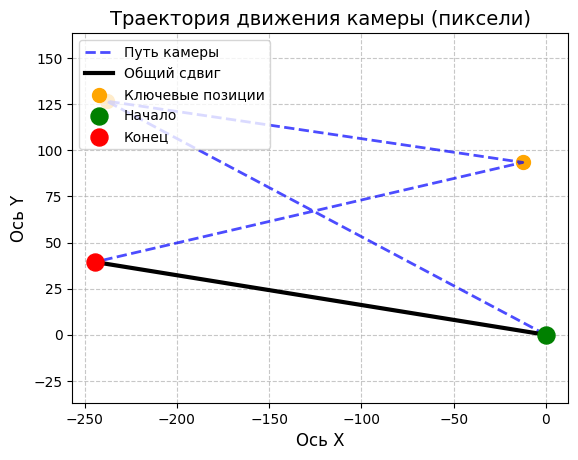

Финальная позиция: (-244.4 px, 39.4 px)
Общий поворот: 13.1 градусов


In [ ]:
# Визуализация траектории

x, y = zip(*trajectory)

# Линия полной траектории
plt.plot(x, y, 'b--', alpha=0.7, linewidth=2, label='Путь камеры')

# Прямая между начальной и конечной точками
plt.plot([x[0], x[-1]], [y[0], y[-1]], 'black', linewidth=3,
         label='Общий сдвиг')

# Маркеры позиций
plt.scatter(x, y, c='orange', s=100, label='Ключевые позиции')
plt.scatter(x[0], y[0], c='green', s=150, label='Начало', zorder=5)
plt.scatter(x[-1], y[-1], c='red', s=150, label='Конец', zorder=5)

# Дополнительные настройки
plt.title('Траектория движения камеры (пиксели)', fontsize=14)
plt.xlabel('Ось X', fontsize=12)
plt.ylabel('Ось Y', fontsize=12)
plt.legend(loc='upper left', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.axis('equal')
plt.show()

print(f"Финальная позиция: ({current_pos[0]:.1f} px, {current_pos[1]:.1f} px)")
print(f"Общий поворот: {total_rotation:.1f} градусов")